# Code to compare train and test stage of DL model


In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns

In [3]:
project_dir = '../'
ml_dir = '{}ml/'.format(project_dir)
results_dir = ml_dir

In [4]:
def read_joules(f,mode):
    joules_df = pd.read_csv(f)
    jcols = joules_df.columns

    regex = re.compile('package_.')
    package_cols = [string for string in jcols if re.match(regex, string)]

    regex = re.compile('dram_.')
    dram_cols = [string for string in jcols if re.match(regex, string)]
    
    joules_df['package_total'] = joules_df[package_cols].sum(axis=1)
    joules_df['dram_total'] = joules_df[dram_cols].sum(axis=1)

    if mode == 'gpu':
        joules_df['nvidia_total'] = joules_df['nvidia_gpu_0']
    else:
        joules_df['nvidia_total'] = 0

    joules_df['process_total'] = joules_df['package_total'] + joules_df['dram_total'] + joules_df['nvidia_total']
    joules_df['mode'] = mode

    return joules_df

In [5]:
experiment_names = ['pytorch_train']
proc_modes = ['cpu']

jcols = ['experiment_name','mode','tag','duration','package_total','dram_total','nvidia_total','process_total']
flops_df_concat = pd.DataFrame()
joules_df_concat = pd.DataFrame()
for exp_name in experiment_names:
    for proc_mode in proc_modes:
        # flops_csv = '{}{}_flops_{}.csv'.format(results_dir,exp_name,proc_mode)
        joules_csv = '{}{}_joules_{}.csv'.format(results_dir,exp_name,proc_mode)
        # flops_df = read_flops(flops_csv,proc_mode)
        # flops_df['experiment_name'] = exp_name
        joules_df = read_joules(joules_csv,proc_mode)
        joules_df['experiment_name'] = exp_name
        # flops_df_concat = flops_df_concat.append(flops_df)
        joules_df_concat = joules_df_concat.append(joules_df[jcols])


joules_df_concat.head()

,experiment_name,mode,tag,duration,package_total,dram_total,nvidia_total,process_total
0,pytorch_train,cpu,forward,0.002995,36682.0,3479.0,0,40161.0
1,pytorch_train,cpu,loss,0.000646,0.0,0.0,0,0.0
2,pytorch_train,cpu,backward,0.007359,91491.0,8911.0,0,100402.0
3,pytorch_train,cpu,step,0.000895,15076.0,1282.0,0,16358.0
4,pytorch_train,cpu,forward,0.001555,32898.0,2380.0,0,35278.0


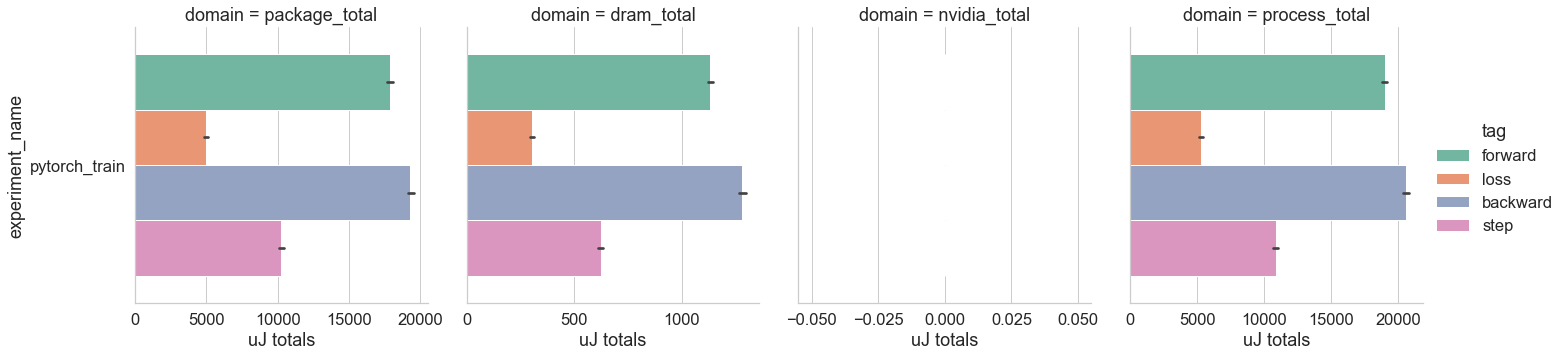

In [7]:
plot_df = joules_df_concat.copy()
plot_df = pd.melt(plot_df, id_vars=['experiment_name','mode','tag','duration'], value_vars=['package_total','dram_total','nvidia_total','process_total'],
 var_name='domain', value_name='uJ totals')
sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='experiment_name',x='uJ totals', hue='tag', col='domain', kind='bar', data=plot_df, palette='Set2',aspect=1, sharex=False)
    # g.set(xscale="log")

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
from ptflops import get_model_complexity_info

sys.path.append('../')
from ml.model import Net

In [26]:
# input
data_path = '{}ml/data'.format(project_dir)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified


In [33]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)
_,n_channels,input_size,_ = images.shape

<class 'torch.Tensor'>
torch.Size([4, 3, 32, 32])
torch.Size([4])


In [25]:
# model complexity
experiment_name = 'pytorch_train'
MODEL_NAME = 'CIFAR'
input_size = 32
n_channels = 3

init_features = 16 #place holder

model_path = '{}cifar_net.pth'.format(ml_dir)

net = Net()
net.load_state_dict(torch.load(model_path))

flops_csv = '{}{}_flops_cpu.csv'.format(output_dir,experiment_name)
macs, params = get_model_complexity_info(net, (n_channels, input_size, input_size), as_strings=True,
                                        print_per_layer_stat=True)

model_info = [MODEL_NAME, input_size, init_features, n_channels, macs, params]

model_info

FileNotFoundError: [Errno 2] No such file or directory: '../ml/cifar_net.pth'